In [1]:
import dimod
import dwave
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite
from dwave.embedding.pegasus import find_clique_embedding

import dwave_networkx as dnx
import networkx as nx
import minorminer

import numpy as np
from matplotlib import pyplot as plt
from tqdm import notebook

import pickle

from OptimizeChainStrength import det_chain_strength

In [5]:
def annealing(H,num_shot,sampler=None,embedding=None,anneal_time=None,chain_strength=10):
    if type(sampler) == None or type(embedding) == None:
        sampler_  = SimulatedAnnealingSampler()
        sampleset = sampler_.sample(H,num_reads=num_shot,answer_mode='raw')
    else:
        sampler_     = FixedEmbeddingComposite(sampler,embedding)
        sampleset    = sampler_.sample(H,num_reads=num_shot,chain_strength=chain_strength,\
                                    answer_mode='raw',annealing_time=anneal_time)
    return sampleset
# fully connected hamiltonian
def FCH(A):
    L = A.shape[0]
    linear = {}
    quadratic = {}
    for i in np.arange(L):
        for j in np.arange(L):
            if A[i][j] != 0:
                quadratic[(i,j)] = A[i][j]
    H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype='SPIN')
    return H                  

def get_confi(confi,embedding):
    qubit_lst = list(embedding.keys())
    confi_ = {}
    for qubit in qubit_lst:
        chains = embedding[qubit]
        chain_confi = np.array([confi[chain] for chain in chains])
        spin = np.random.choice(chain_confi)
        confi_[qubit] = spin
    return confi_

def check_chain_break(confi,embedding):
    for chains in embedding.values():
        lst = []
        for chain in chains:
            lst.append(confi[chain])
        if np.abs(np.mean(lst)) != 1:
            return True
    return False

def find_embedding(source,target,initial=None):
    if type(initial) != type(None):
        embedding = minorminer.find_embedding(source.edges(),target.edges(),initial_chains=initial)
    else:
        embedding = minorminer.find_embedding(source.edges(),target.edges())
    return embedding

def ret_num_chain(embedding):
    cnt = 0
    for val in embedding.values():
        cnt += len(val) - 1
    return cnt

def defaultJc(H,prefactor=1.414):
    num_interactions = H.num_interactions
    quadratic_array = np.fromiter(H.quadratic.values(), dtype=float, count=num_interactions)    
    squared_j = quadratic_array**2
    rms = np.sqrt(squared_j.sum() / num_interactions)
    avg_degree = H.degrees(array=True).mean()
    Jc = prefactor * rms * np.sqrt(avg_degree)   
    return Jc

In [3]:
sampler            = DWaveSampler(solver='Advantage_system6.3',\
                                  token='yXwP-14c5f07f8c1e275a1e6d06fe2b5bd641bce661fa')
print("Connected to sampler", sampler.solver.name)
pegasus_properties = sampler.properties
pegasus_graph      = sampler.to_networkx_graph()

Connected to sampler Advantage_system6.3


In [7]:
L    = 20
seed = 0
A    = np.random.normal(size=(L,L))
A    = (A + A.T) / 2
H    = FCH(A)
G    = dimod.to_networkx_graph(H)

In [9]:
embedding  = find_clique_embedding(L,target_graph=pegasus_graph)
embedding_ = {}
for qubit, chains in embedding.items():
    for chain in chains:
        embedding_[chain] = (chain,)

In [10]:
embedding

{0: (180, 181, 2940),
 1: (195, 196, 2955),
 2: (150, 151, 2970),
 3: (165, 166, 2985),
 4: (210, 211, 3000),
 5: (225, 226, 3015),
 6: (240, 241, 3240),
 7: (255, 256, 3255),
 8: (270, 271, 3030),
 9: (285, 286, 3045),
 10: (300, 301, 3210),
 11: (315, 316, 3225),
 12: (90, 3150, 3151),
 13: (105, 3165, 3166),
 14: (330, 3060, 3061),
 15: (345, 3075, 3076),
 16: (361, 3090, 3091),
 17: (376, 3105, 3106),
 18: (60, 3120, 3121),
 19: (75, 3135, 3136)}

In [55]:
L_lst          = np.array([20,30,40,50])
A_lst          = []
H_lst          = []
embedding_lst  = []
embedding_lst_ = []
for L in L_lst:
    A    = np.random.normal(size=(L,L))
    A    = (A + A.T) / 2
    H    = FCH(A)    
    embedding  = find_clique_embedding(L,target_graph=pegasus_graph)
    embedding_ = {}
    for qubit, chains in embedding.items():
        for chain in chains:
            embedding_[chain] = (chain,)    
    A_lst.append(A)
    H_lst.append(H)
    embedding_lst.append(embedding)
    embedding_lst_.append(embedding_)

In [56]:
num_shot      = 1000
anneal_time   = 700
Lnum          = L_lst.shape[0]
sampleset_lst = []
for i in notebook.tqdm(np.arange(Lnum)):
    H             = H_lst[i]
    embedding     = embedding_lst[i]
    embedding_    = embedding_lst_[i]
    Jc            = defaultJc(H)
    H_            = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
    sampleset     = annealing(H_,num_shot,sampler,embedding_,anneal_time)    
    sampleset_lst.append(sampleset) 

  0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
sampleset_lst_default = sampleset_lst

In [58]:
num_shot      = 100
anneal_time   = 1000
Lnum          = L_lst.shape[0]
Sampleset_lst = []
num           = 10
Jc_lst        = []
for i in notebook.tqdm(np.arange(Lnum)):
    sampleset_lst = []
    H             = H_lst[i]
    embedding     = embedding_lst[i]
    embedding_    = embedding_lst_[i]
    init_Jc       = defaultJc(H)
    init_Jc_lst   = np.linspace(init_Jc/10,init_Jc,num=num)
    for j in np.arange(num):
        Jc        = init_Jc_lst[j]
        H_        = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
        sampleset = annealing(H_,num_shot,sampler,embedding_,anneal_time)
        sampleset_lst.append(sampleset)
        confi     = sampleset.first.sample
        if check_chain_break(confi,embedding) == False:
            if j == 0:
                Jc_ = init_Jc_lst[0]
            else:
                Jc_ = init_Jc_lst[j-1]
            Jc_lst.append(Jc_)
            break     
    Sampleset_lst.append(sampleset_lst)

  0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
Sampleset_lst_test = Sampleset_lst

In [60]:
Jc_lst

[4.4027030011547215, 4.431472457375955, 7.550769467021383, 8.36026635820082]

In [61]:
for H in H_lst:
    print(defaultJc(H))

8.805406002309443
11.078681143439889
12.584615778368972
13.933777263668032


In [72]:
num_shot      = 1000
anneal_time   = 700
cnst          = 1.8
sampleset_lst = []
for i in notebook.tqdm(np.arange(Lnum)):
    H = H_lst[i]
    embedding = embedding_lst[i]
    embedding_ = embedding_lst_[i]
    Jc        = cnst * Jc_lst[i]
    H_        = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
    sampleset = annealing(H_,num_shot,sampler,embedding_,anneal_time)
    sampleset_lst.append(sampleset)    

  0%|          | 0/4 [00:00<?, ?it/s]

In [73]:
sampleset_lst1_8 = sampleset_lst

In [74]:
ener_lst      = []
sampleset_lst = sampleset_lst1_8
for i in notebook.tqdm(np.arange(Lnum)):
    H = H_lst[i]
    embedding = embedding_lst[i]
    sampleset = sampleset_lst[i]
    confi     = sampleset.first.sample
    E         = 0
    if check_chain_break(confi,embedding) == False:
        cnt = 0
        for sample in sampleset.samples():
            if check_chain_break(sample,embedding) == False:
                sample_ = get_confi(sample,embedding)
                E      += H.energy(sample_)
                cnt    += 1
    E /= cnt
    ener_lst.append(E)
ener_lst = np.array(ener_lst)

  0%|          | 0/4 [00:00<?, ?it/s]

In [75]:
# default, 1.4, 1.6, 1.8
ener_lst1_8 = ener_lst

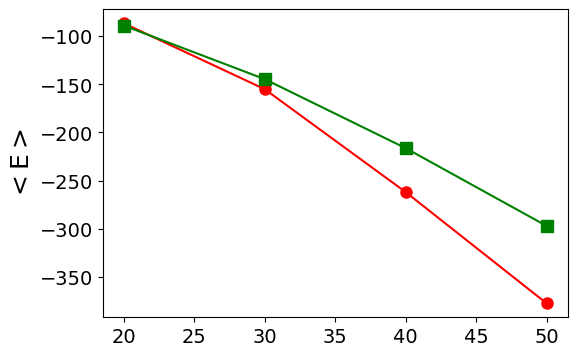

In [82]:
ssize                          = 8
markersize                     = 10
plt.rcParams["font.size"]      = 14
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(L_lst,ener_lst1_4,color='r',marker='o',markersize=ssize)
# plt.plot(L_lst,ener_lst1_6,color='b',marker='^',markersize=ssize)
# plt.plot(L_lst,ener_lst1_8,color='m',marker='d',markersize=ssize)
plt.plot(L_lst,ener_lst_default,color='g',marker='s',markersize=ssize)
plt.ylabel('$<\\text{E}>$',fontsize=18)
plt.show()